In [11]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [12]:
pokemon_df = pd.read_csv('pokemon.csv')
pokemon_df = pokemon_df.set_index('#')
combats_df = pd.read_csv('combats.csv')
pokemon_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 1 to 800
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        799 non-null    object
 1   Type 1      800 non-null    object
 2   Type 2      414 non-null    object
 3   HP          800 non-null    int64 
 4   Attack      800 non-null    int64 
 5   Defense     800 non-null    int64 
 6   Sp. Atk     800 non-null    int64 
 7   Sp. Def     800 non-null    int64 
 8   Speed       800 non-null    int64 
 9   Generation  800 non-null    int64 
 10  Legendary   800 non-null    bool  
dtypes: bool(1), int64(7), object(3)
memory usage: 69.5+ KB


In [13]:
pokemon_df['Type 2'].fillna('empty',inplace=True)
pokemon_df['Type 2'].value_counts()

empty       386
Flying       97
Ground       35
Poison       34
Psychic      33
Fighting     26
Grass        25
Fairy        23
Steel        22
Dark         20
Dragon       18
Ice          14
Rock         14
Water        14
Ghost        14
Fire         12
Electric      6
Normal        4
Bug           3
Name: Type 2, dtype: int64

In [14]:
pokemon_df['Type 1'] = pokemon_df['Type 1'].astype('category')
pokemon_df['Type 2'] = pokemon_df['Type 2'].astype('category')
pokemon_df['Legendary'] = pokemon_df['Legendary'].astype('int64')
pokemon_df.dtypes

Name            object
Type 1        category
Type 2        category
HP               int64
Attack           int64
Defense          int64
Sp. Atk          int64
Sp. Def          int64
Speed            int64
Generation       int64
Legendary        int64
dtype: object

In [15]:
df_type1_one_hot = pd.get_dummies(pokemon_df['Type 1'])
df_type2_one_hot = pd.get_dummies(pokemon_df['Type 2'])
combine = df_type1_one_hot.add(df_type2_one_hot,fill_value=0).astype('int64')
pd.options.display.max_columns = 30
pokemon_df = pokemon_df.join(combine)
pokemon_df.head

<bound method NDFrame.head of                Name   Type 1  Type 2  HP  Attack  Defense  Sp. Atk  Sp. Def  \
#                                                                             
1         Bulbasaur    Grass  Poison  45      49       49       65       65   
2           Ivysaur    Grass  Poison  60      62       63       80       80   
3          Venusaur    Grass  Poison  80      82       83      100      100   
4     Mega Venusaur    Grass  Poison  80     100      123      122      120   
5        Charmander     Fire   empty  39      52       43       60       50   
..              ...      ...     ...  ..     ...      ...      ...      ...   
796         Diancie     Rock   Fairy  50     100      150      100      150   
797    Mega Diancie     Rock   Fairy  50     160      110      160      110   
798  Hoopa Confined  Psychic   Ghost  80     110       60      150      130   
799   Hoopa Unbound  Psychic    Dark  80     160       60      170      130   
800       Volcanion   

In [16]:
pokemon_df['Type 1'] = pokemon_df['Type 1'].cat.codes
pokemon_df['Type 2'] = pokemon_df['Type 2'].cat.codes
pokemon_df.head

<bound method NDFrame.head of                Name  Type 1  Type 2  HP  Attack  Defense  Sp. Atk  Sp. Def  \
#                                                                            
1         Bulbasaur       9      13  45      49       49       65       65   
2           Ivysaur       9      13  60      62       63       80       80   
3          Venusaur       9      13  80      82       83      100      100   
4     Mega Venusaur       9      13  80     100      123      122      120   
5        Charmander       6      18  39      52       43       60       50   
..              ...     ...     ...  ..     ...      ...      ...      ...   
796         Diancie      15       4  50     100      150      100      150   
797    Mega Diancie      15       4  50     160      110      160      110   
798  Hoopa Confined      14       8  80     110       60      150      130   
799   Hoopa Unbound      14       1  80     160       60      170      130   
800       Volcanion       6      1

In [17]:
pokemon_df.drop('Name', axis='columns',inplace=True)
pokemon_df.head()

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water,empty
#,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,9,13,45,49,49,65,65,45,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,9,13,60,62,63,80,80,60,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,9,13,80,82,83,100,100,80,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4,9,13,80,100,123,122,120,80,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
5,6,18,39,52,43,60,50,65,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [18]:
combats_df['Winner'] = combats_df.apply(lambda x:0
                                        if x.Winner == x.First_pokemon else 1,
                                        axis='columns')
combats_df.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,1
1,702,701,1
2,191,668,1
3,237,683,1
4,151,231,0


In [19]:
data_num = combats_df.shape[0]
indexes = np.random.permutation(data_num)
train_indexes = indexes[:int(data_num*0.6)]
val_indexes = indexes[int(data_num*0.6):int(data_num*0.8)]
test_indexes = indexes[int(data_num*0.8):]
train_data = combats_df.loc[train_indexes]
val_data = combats_df.loc[val_indexes]
test_data = combats_df.loc[test_indexes]


In [20]:
pokemon_df['Type 1'] = pokemon_df['Type 1']/19
pokemon_df['Type 2'] = pokemon_df['Type 2']/19

mean  = pokemon_df.loc[:,"HP":'Generation'].mean()
std = pokemon_df.loc[:,"HP":'Generation'].std()
pokemon_df.loc[:,"HP":'Generation'] = (pokemon_df.loc[:,"HP":'Generation']-mean) / std

pokemon_df.head()

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water,empty
#,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.473684,0.684211,-0.950032,-0.924328,-0.796655,-0.238981,-0.248033,-0.801002,-1.398762,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,0.473684,0.684211,-0.362595,-0.523803,-0.347700,0.219422,0.290974,-0.284837,-1.398762,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,0.473684,0.684211,0.420654,0.092390,0.293665,0.830626,1.009651,0.403383,-1.398762,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4,0.473684,0.684211,0.420654,0.646964,1.576395,1.502951,1.728328,0.403383,-1.398762,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
5,0.315789,0.947368,-1.185007,-0.831899,-0.989065,-0.391782,-0.787041,-0.112782,-1.398762,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [21]:
x_train_index = np.array(train_data.drop('Winner',axis='columns'))
x_val_index = np.array(val_data.drop('Winner',axis='columns'))
x_test_index = np.array(test_data.drop('Winner',axis='columns'))
print(x_train_index)


[[624 554]
 [313 614]
 [681 629]
 ...
 [440 704]
 [ 97 240]
 [165 566]]


In [22]:
y_train = np.array(train_data['Winner'])
y_val = np.array(val_data['Winner'])
y_test = np.array(test_data['Winner'])



In [23]:
pokemon_data_normal = np.array(pokemon_df.loc[:,:'Legendary'])
x_train_normal = pokemon_data_normal[x_train_index - 1].reshape(-1, 20)
x_val_normal = pokemon_data_normal[x_val_index - 1].reshape(-1, 20)
x_test_normal = pokemon_data_normal[x_test_index - 1].reshape(-1, 20)


In [24]:
pokemon_data_one_hot = np.array(pokemon_df.loc[:,'HP':])
x_train_one_hot = pokemon_data_one_hot[x_train_index - 1].reshape((-1, 54))
x_val_one_hot = pokemon_data_one_hot[x_val_index - 1].reshape((-1, 54))
x_test_one_hot = pokemon_data_one_hot[x_test_index - 1].reshape((-1, 54))


In [34]:
inputs = keras.Input(shape=(20,))
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_1 = keras.Model(inputs, outputs)
model_1.summary()


Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                1344      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 5,569
Trainable params: 5,569
Non-trainable params: 0
____________________________________________________

In [35]:
model_1.compile(keras.optimizers.Adam(),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=[keras.metrics.BinaryAccuracy()])

model_1_dir = 'lab3-logs/models/model-1'

try:
    os.makedirs(model_1_dir)
except FileExistsError:
    pass

log_1_dir = os.path.join('lab3-logs','model-1')
model_cbk = keras.callbacks.TensorBoard(log_1_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_1_dir + '/best_model.h5'
                                             ,save_best_only=True
                                             ,monitor='val_binary_accuracy'
                                             ,mode='max')

history_1 = model_1.fit(x_train_normal, y_train
                        ,batch_size=64
                        ,epochs=100
                        ,validation_data=(x_val_normal,y_val)
                        ,callbacks=[model_cbk,model_mckp])
                                             


Epoch 1/100
469/469 [==============================] - 2s 4ms/step - loss: 0.4040 - binary_accuracy: 0.8432 - val_loss: 0.3354 - val_binary_accuracy: 0.9061
Epoch 2/100
469/469 [==============================] - 2s 4ms/step - loss: 0.3278 - binary_accuracy: 0.8935 - val_loss: 0.2788 - val_binary_accuracy: 0.9247
Epoch 3/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2790 - binary_accuracy: 0.9102 - val_loss: 0.2301 - val_binary_accuracy: 0.9361
Epoch 4/100
469/469 [==============================] - 2s 4ms/step - loss: 0.2442 - binary_accuracy: 0.9236 - val_loss: 0.2127 - val_binary_accuracy: 0.9364
Epoch 5/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2249 - binary_accuracy: 0.9286 - val_loss: 0.1951 - val_binary_accuracy: 0.9402
Epoch 6/100
469/469 [==============================] - 2s 5ms/step - loss: 0.2089 - binary_accuracy: 0.9328 - val_loss: 0.1875 - val_binary_accuracy: 0.9425
Epoch 7/100
469/469 [==============================] - 2s 

In [37]:
inputs = keras.Input(shape=(54,))
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_2 = keras.Model(inputs, outputs)
model_2.summary()

model_2.compile(keras.optimizers.Adam(),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=[keras.metrics.BinaryAccuracy()])

model_2_dir = 'lab3-logs/models/model-2'

try:
    os.makedirs(model_2_dir)
except FileExistsError:
    pass

log_2_dir = os.path.join('lab3-logs','model-2')
model_cbk = keras.callbacks.TensorBoard(log_2_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_2_dir + '/best_model-2.h5'
                                             ,save_best_only=True
                                             ,monitor='val_binary_accuracy'
                                             ,mode='max')

history_2 = model_2.fit(x_train_normal, y_train
                        ,batch_size=64
                        ,epochs=100
                        ,validation_data=(x_val_normal,y_val)
                        ,callbacks=[model_cbk,model_mckp])
                                             

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 54)]              0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                3520      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

ValueError: in user code:

    c:\Users\ASUS\anaconda3\envs\tf2_NTUT\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    c:\Users\ASUS\anaconda3\envs\tf2_NTUT\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\Users\ASUS\anaconda3\envs\tf2_NTUT\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\Users\ASUS\anaconda3\envs\tf2_NTUT\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\Users\ASUS\anaconda3\envs\tf2_NTUT\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\Users\ASUS\anaconda3\envs\tf2_NTUT\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    c:\Users\ASUS\anaconda3\envs\tf2_NTUT\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    c:\Users\ASUS\anaconda3\envs\tf2_NTUT\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    c:\Users\ASUS\anaconda3\envs\tf2_NTUT\lib\site-packages\tensorflow\python\keras\engine\functional.py:386 call
        inputs, training=training, mask=mask)
    c:\Users\ASUS\anaconda3\envs\tf2_NTUT\lib\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    c:\Users\ASUS\anaconda3\envs\tf2_NTUT\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    c:\Users\ASUS\anaconda3\envs\tf2_NTUT\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer dense_14 is incompatible with the layer: expected axis -1 of input shape to have value 54 but received input with shape [None, 20]


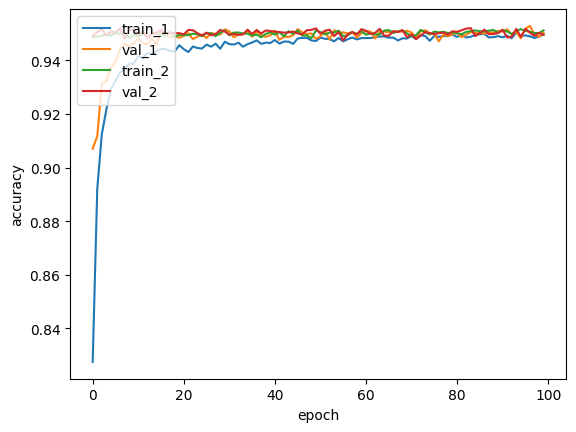

In [ ]:
plt.plot(history_1.history['binary_accuracy'])
plt.plot(history_1.history['val_binary_accuracy'])
plt.plot(history_2.history['binary_accuracy'])
plt.plot(history_2.history['val_binary_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_1', 'val_1','train_2','val_2'], loc='upper left')

In [33]:
model_1.load_weights(model_1_dir + '/best_model.h5')
model_2.load_weights(model_2_dir + '/best_model-2.h5')
loss_1, acc_1 = model_1.evaluate(x_test_normal, y_test)
loss_2 ,acc_2 = model_2.evaluate(x_test_one_hot, y_test)
print('model_1 accuracy:', acc_1)
print('model_2 accuracy:', acc_2)

ValueError: You are trying to load a weight file containing 3 layers into a model with 4 layers.